In [1]:
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
import numba
import ultranest
import functools
from numba import njit

import scipy.special as sc
import ctypes
from numba.extending import get_cython_function_address

name_and_types_to_pointer = {('erfinv', numba.types.float64): ctypes.CFUNCTYPE(ctypes.c_double, ctypes.c_double)(get_cython_function_address('scipy.special.cython_special', 'erfinv'))}

def choose_kernel(name, all_signatures):
    def choice_function(*args):
        for signature in all_signatures:
            if args == signature:
                f = name_and_types_to_pointer[(name, *signature)]
                return lambda *args: f(*args)
    return choice_function

all_signatures = [(numba.types.float64,)]
name = 'erfinv'
sc_function = getattr(sc, name)
numba.extending.overload(sc_function)(choose_kernel(name, all_signatures))

sc_erfinv = getattr(sc, name)
@numba.njit
def numba_erfinv(*args):
    return sc_erfinv(*args)

import tensorflow.config.experimental as tfce
gpus = tfce.list_physical_devices('GPU')

if gpus:
    try:
        tfce.set_virtual_device_configuration(gpus[0], [tfce.VirtualDeviceConfiguration(memory_limit=1024)])
    except RuntimeError as e:
        print(e)

In [3]:
q_model = load_model("final_emulator/final_model_q")
u_model = load_model("final_emulator/final_model_u")

#q_scaler_data = load(open("scaler_data_q.pkl", "rb"))
#u_scaler_data = load(open("scaler_data_u.pkl", "rb"))
#
#q_scaler_parameters = load(open("scaler_parameters_q.pkl", "rb"))
#u_scaler_parameters = load(open("scaler_parameters_u.pkl", "rb"))
#
#q_params_mean = q_scaler_parameters.mean_
#q_params_std = q_scaler_parameters.scale_
#q_data_mean = q_scaler_data.mean_
#q_data_std = q_scaler_data.scale_
#
#u_params_mean = u_scaler_parameters.mean_
#u_params_std = u_scaler_parameters.scale_
#u_data_mean = u_scaler_data.mean_
#u_data_std = u_scaler_data.scale_

In [4]:
scaler_params_df = pd.read_csv("final_emulator/parameters_scaler.csv", index_col=0)
scaler_data_df = pd.read_csv("final_emulator/data_scaler.csv", index_col=0)

In [5]:
q_params_mean = scaler_params_df.loc["q_mean"].values
q_params_std = scaler_params_df.loc["q_std"].values
q_data_mean = scaler_data_df.loc["q_mean"].values
q_data_std = scaler_data_df.loc["q_std"].values

u_params_mean = scaler_params_df.loc["u_mean"].values
u_params_std = scaler_params_df.loc["u_std"].values
u_data_mean = scaler_data_df.loc["u_mean"].values
u_data_std = scaler_data_df.loc["u_std"].values

In [6]:
from astropy.io import ascii

def rotate_pa(PA, Q, U, sig_q, sig_u, index, adjust=0):
    p = np.sqrt(Q**2 + U **2)
    sig_pa = (1 / p) * np.sqrt((Q * sig_q)**2 + (U * sig_u)**2)
    mean_pa = np.average(PA[index] + adjust, weights = 1./sig_pa[index]**2)
    
    print("Mean PA: ", mean_pa)
    q_rot = np.sqrt(Q**2 + U**2)*np.cos(2*np.deg2rad(PA - mean_pa))
    u_rot = np.sqrt(Q**2 + U**2)*np.sin(2*np.deg2rad(PA - mean_pa))

    return q_rot, u_rot

def calculate_PA(Q, U):
    
    PA = np.rad2deg(0.5*np.arctan2(U, Q))
    i=0
    for pa in PA:
        if pa < 0:
            PA[i] = pa + 180
        i+=1
    
    return PA

def q_prime(x, q00, P_max, thetaIS, lambda_max, k):
    return q00 + P_max * np.cos(2 * np.deg2rad(thetaIS + k/x)) * np.exp(-1.7 * lambda_max * np.log(lambda_max / x)**2)
def u_prime(x, u00, P_max, thetaIS, lambda_max, k):
    return u00 + P_max * np.sin(2 * np.deg2rad(thetaIS + k/x)) * np.exp(-1.7 * lambda_max * np.log(lambda_max / x)**2)

def d_dp_qprime(x, thetaIS, lambda_max, k):
    return np.cos(2 * np.deg2rad(thetaIS + k/x)) * np.exp(-1.7 * lambda_max * np.log(lambda_max / x)**2)

def d_dp_uprime(x, thetaIS, lambda_max, k):
    return np.sin(2 * np.deg2rad(thetaIS + k/x)) * np.exp(-1.7 * lambda_max * np.log(lambda_max / x)**2)

def d_dt_qprime(x, P_max, thetaIS, lambda_max, k):
    return -2 * P_max * np.sin(2 * np.deg2rad(thetaIS + k/x)) * np.exp(-1.7 * lambda_max * np.log(lambda_max / x)**2)

def d_dt_uprime(x, P_max, thetaIS, lambda_max, k):
    return 2 * P_max * np.cos(2 * np.deg2rad(thetaIS + k/x)) * np.exp(-1.7 * lambda_max * np.log(lambda_max / x)**2)

def d_dlam_qprime(x, P_max, thetaIS, lambda_max, k):
    return -1.7 * P_max * np.exp(-1.7 * lambda_max * np.log(lambda_max / x)**2) * \
np.log(lambda_max / x) * (np.log(lambda_max / x) + 2) * np.cos(2 * np.deg2rad(thetaIS + k/x))

def d_dlam_uprime(x, P_max, thetaIS, lambda_max, k):
    return -1.7 * P_max * np.exp(-1.7 * lambda_max * np.log(lambda_max / x)**2) * \
np.log(lambda_max / x) * (np.log(lambda_max / x) + 2) * np.cos(2 * np.deg2rad(thetaIS + k/x))

def d_dk_qprime(x, P_max, thetaIS, lambda_max, k):
    return -2 / x * P_max * np.sin(2 * np.deg2rad(thetaIS + k/x)) * np.exp(-1.7 * lambda_max * np.log(lambda_max / x)**2)

def d_dk_uprime(x, P_max, thetaIS, lambda_max, k):
    return 2 / x * P_max * np.cos(2 * np.deg2rad(thetaIS + k/x)) * np.exp(-1.7 * lambda_max * np.log(lambda_max / x)**2)

def q_prime_sigma(x, q00, q00_sig, P_max, P_max_sig, thetaIS, thetaIS_sig, lambda_max, lambda_max_sig, k, k_sig):
    a = q00_sig
    b = P_max_sig * d_dp_qprime(x, thetaIS, lambda_max, k)
    c = np.deg2rad(thetaIS_sig) * d_dt_qprime(x, P_max, thetaIS, lambda_max, k)
    d = lambda_max_sig * d_dlam_qprime(x, P_max, thetaIS, lambda_max, k)
    e = np.deg2rad(k_sig) * d_dk_qprime(x, P_max, thetaIS, lambda_max, k)
    
    return np.sqrt(a**2 + b**2 + c**2 + d**2 + e**2)

def u_prime_sigma(x, u00, u00_sig, P_max, P_max_sig, thetaIS, thetaIS_sig, lambda_max, lambda_max_sig, k, k_sig):
    a = u00_sig
    b = P_max_sig * d_dp_uprime(x, thetaIS, lambda_max, k)
    c = np.deg2rad(thetaIS_sig) * d_dt_uprime(x, P_max, thetaIS, lambda_max, k)
    d = lambda_max_sig * d_dlam_uprime(x, P_max, thetaIS, lambda_max, k)
    e = np.deg2rad(k_sig) * d_dk_uprime(x, P_max, thetaIS, lambda_max, k)
    
    return np.sqrt(a**2 + b**2 + c**2 + d**2 + e**2)

def wrap(c):
    return np.concatenate((c,c,c,c,c))
def phase_wrap(a):
    return np.concatenate((a-2,a-1,a,a+1,a+2))

# WR42

# WR 79

-0.0028386074062398048 0.0001961256098477405 -0.002139044107623792 0.00025159143202954914


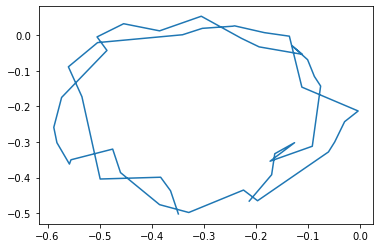

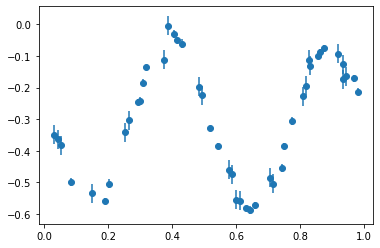

In [7]:
WR79_data = ascii.read("wr_data/WR79_stlouis_bvband_line_pol.txt", data_start=1)

#WR42_data["Phase"] -= 0.5

for i, phase in enumerate(WR79_data["Phase"]):
    if phase < 0:
        WR79_data["Phase"][i] += 1

WR79_data.sort("Phase")


#Filter central wavelengths
#U = 3650A, B = 4450A, V = 5510A, R = 6580A, I = 8060A
lam = 4700*1e-4


q_ISP = q_prime(lam, 0.0, 0.376, -81.5, 0.595, 4.7)
u_ISP = u_prime(lam, 0.0, 0.376, -81.5, 0.595, 4.7)

q_ISP_sig = q_prime_sigma(lam, 0.0, 0.0, 0.376, 0.007, -81.5, 1.8, 0.595, 0.015, 4.7, 0.8)
u_ISP_sig = u_prime_sigma(lam, 0.0, 0.0, 0.376, 0.007, -81.5, 1.8, 0.595, 0.015, 4.7, 0.8)

q_ISP/=100
u_ISP/=100

q_ISP_sig/=100
u_ISP_sig/=100

q_data, u_data = WR79_data["%Q"], WR79_data["%U"]

#q_data -= q_ISP
#u_data -= u_ISP

plt.plot(q_data, u_data)

q_data /= 100
u_data /= 100

qerr = uerr = (WR79_data["%Err"] / 100)

phase = WR79_data["Phase"]
plt.figure()
plt.errorbar(x=phase, y=q_data * 100, yerr=qerr * 100,
             marker='o', ls=' ')

print(q_ISP, q_ISP_sig, u_ISP, u_ISP_sig)

# WR 127

# WR 153

In [8]:
@njit
def sample_normal(theta, mu, sigma):
    return mu + sigma * np.sqrt(2) * numba_erfinv(2 * theta - 1)

@numba.guvectorize([(numba.float64[:], numba.float64[:], numba.float64[:], numba.float64[:])], \
                   '(n),(m),(m)->(n)', target='cpu', nopython=True, fastmath=True)
def simple_transform(X, mean, std, y):
    y[:] = X
    y -= mean
    y /= std

@numba.guvectorize([(numba.float64[:], numba.float64[:], numba.float64[:], numba.float64[:])], \
                   '(n),(m),(m)->(n)', target='cpu', nopython=True, fastmath=True)
def simple_inverse_transform(X, mean, std, y):
    y[:] = X
    y *= std
    y += mean
    
model_phase = np.linspace(0, 1, 40, endpoint=False) + 1/80 + 0.5

@functools.partial(np.vectorize, signature='(m),()->(k)')
def interp_vectorized_offset(predictions, offset):
    interpolated = np.interp(phase, model_phase + offset, predictions, period=1.0)
    return interpolated

@functools.partial(np.vectorize, signature='(m)->(k)')
def interp_vectorized(predictions):
    interpolated = np.interp(phase, model_phase, predictions, period=1.0)
    return interpolated

@functools.partial(np.vectorize, signature='(m),()->(k)')
def vec_sum(x1, x2):
    y = x1 + x2
    return y
    
@functools.partial(np.vectorize, signature='(m,n)->(m,k)')
def q_transform_function(X):
    X_scaled = simple_transform(X[:,:4], q_params_mean, q_params_std)
    predictions_scaled = q_model(X_scaled).numpy()
    predictions = simple_inverse_transform(predictions_scaled, q_data_mean, q_data_std)
    #predictions_int = interp_vectorized_offset(predictions, X[:,4])
    predictions_int = interp_vectorized(predictions)
    #predictions_final = vec_sum(predictions_int, X[:,5])
    return predictions_int

@functools.partial(np.vectorize, signature='(m,n)->(m,k)')
def q_transform_function_nointerp(X):
    X_scaled = simple_transform(X[:,:4], q_params_mean, q_params_std)
    predictions_scaled = q_model(X_scaled).numpy()
    predictions = simple_inverse_transform(predictions_scaled, q_data_mean, q_data_std)
    #predictions_final = vec_sum(predictions, X[:,5])
    return predictions

@functools.partial(np.vectorize, signature='(m,n)->(m,k)')
def u_transform_function(X):
    X_scaled = simple_transform(X[:,:4], u_params_mean, u_params_std)
    predictions_scaled = u_model(X_scaled).numpy()
    predictions = simple_inverse_transform(predictions_scaled, u_data_mean, u_data_std)
    #predictions_int = interp_vectorized_offset(predictions, X[:,4])
    predictions_int = interp_vectorized(predictions)
    #predictions_final = vec_sum(predictions_int, X[:,6])
    return predictions_int

@functools.partial(np.vectorize, signature='(m,n)->(m,k)')
def u_transform_function_nointerp(X):
    X_scaled = simple_transform(X[:,:4], u_params_mean, u_params_std)
    predictions_scaled = u_model(X_scaled).numpy()
    predictions = simple_inverse_transform(predictions_scaled, u_data_mean, u_data_std)
    #predictions_final = vec_sum(predictions, X[:,6])
    return predictions

@numba.guvectorize([(numba.float64[:], numba.float64[:])], '(n)->(n)', target='cpu', nopython=True, fastmath=True)
def prior_transform(cube, params):
      
    # nsrc
    params[0] = cube[0]
    # tau
    params[1] = cube[1]
    # exponential sampling tau
    #params[1] = -np.log(1.0 - cube[1])
    
    # ellipse_z
    hi = 3.1
    lo = 0.2
    params[2] = cube[2] * (hi - lo) + lo
    
    # inclination angle i
    hi = 1.0
    lo = -1.0
    params[3] = cube[3] * (hi - lo) + lo
    # offset
    hi = np.pi/2
    lo = -np.pi/2
    params[4] = cube[4] * (hi - lo) + lo
    
    # q00
    mu = q_ISP
    sigma = q_ISP_sig
    params[5] = sample_normal(cube[5], mu, sigma)
    # u00
    mu = u_ISP
    sigma = u_ISP_sig
    params[6] = sample_normal(cube[6], mu, sigma)

In [9]:
@functools.partial(np.vectorize, signature='(n),(n),(n),()->(n)')
def rotate_q(Q, U, PA, X):
    q_rot = np.sqrt(Q**2 + U**2)*np.cos(2 * (PA - X))
    return q_rot

@functools.partial(np.vectorize, signature='(n),(n),(n),()->(n)')
def rotate_u(Q, U, PA, X):
    u_rot = np.sqrt(Q**2 + U**2)*np.sin(2 * (PA - X))
    return u_rot
    
@functools.partial(np.vectorize, signature='(n),(n)->(n)')
def calculate_PA(Q, U):
    PA = 0.5*np.arctan2(U, Q)
    return PA

In [10]:
@functools.partial(np.vectorize, signature='(n,m)->(n)')
def log_likelihood_ultra(x):    
    emulated_q = q_transform_function(x)
    emulated_u = u_transform_function(x)
    
    pa = calculate_PA(emulated_q, emulated_u)
    
    rotated_q = rotate_q(emulated_q, emulated_u, pa, x[:,4])    
    rotated_u = rotate_u(emulated_q, emulated_u, pa, x[:,4])
    
    prediction_q = vec_sum(rotated_q, x[:,5])
    prediction_u = vec_sum(rotated_u, x[:,6])
    
    return -0.5 * (((prediction_q - q_data)/qerr) ** 2 + ((prediction_u - u_data)/uerr) ** 2).sum(axis=1)

In [11]:
!export OMP_NUM_THREADS=48

In [13]:
param_names = ["nsrc", "tau", "ellipse_z", "i", "offset", "q00", "u00"]

sampler = ultranest.ReactiveNestedSampler(
    param_names, 
    log_likelihood_ultra,
    prior_transform, 
    vectorized=True, 
    ndraw_min=4096, 
    wrapped_params=[False, False, False, False, True, False, False],
    log_dir="wr_79",
)
result = sampler.run(frac_remain=0.5, min_num_live_points=800, max_ncalls=4e6)

Creating directory for new run wr_79/run4
[ultranest] Sampling 800 live points from prior ...


/home/afullard/.conda/envs/emulator/lib/python3.9/site-packages/ultranest/integrator.py:1601: UserWarning: Sampling from region seems inefficient (0/4096 accepted in iteration 25). To improve efficiency, modify the transformation so that the current live points (stored for you in wr_79/run4/extra/sampling-stuck-it%d.csv) are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)


[ultranest] Explored until L=-9e+01   [-95.4426..-95.4385]*| it/evals=15355/4000085 eff=0.3839% N=800    
[ultranest] Likelihood function evaluations: 4000085
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest] Reached maximum number of likelihood calls (4000085 > 4000000)...
[ultranest] done iterating.


In [14]:
nsteps = 4 * len(param_names)
# create step sampler:
sampler.stepsampler = ultranest.stepsampler.RegionSliceSampler(nsteps=nsteps)

In [15]:
result = sampler.run(min_num_live_points=800)
sampler.print_results()

[ultranest] Widening roots to 800 live points (have 800 already) ...


[ultranest] Explored until L=-9e+01  8 [-89.3908..-89.3906]*| it/evals=21708/4911637 eff=0.6968% N=800 
[ultranest] Likelihood function evaluations: 4911637
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -111.9 +- 0.1457
[ultranest] Effective samples strategy satisfied (ESS = 4836.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.37, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.

logZ = -111.813 +- 0.185
  single instance: logZ = -111.813 +- 0.158
  bootstrapped   : logZ = -111.869 +- 0.184
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    nsrc                0.753 +- 0.068
    tau                 0.314 +- 0.087
    ellipse_z           1.504 +- 0.02

In [16]:
sampler.store_tree()

In [17]:
sampler.plot_corner()

In [18]:
sampler.plot_trace()

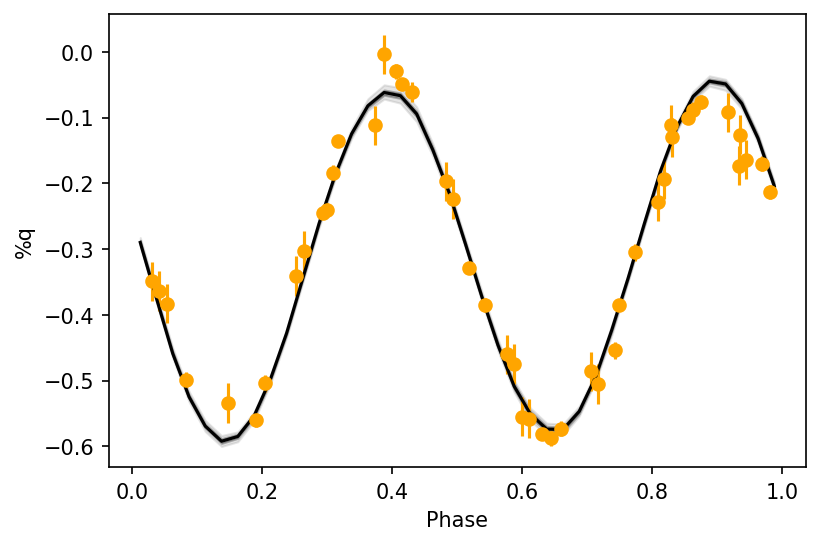

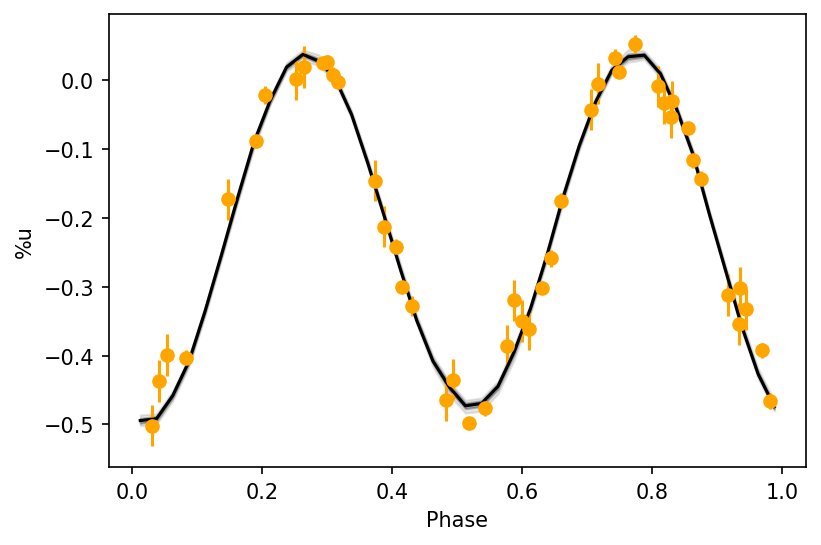

In [19]:
def transform_for_band(x):    
    emulated_q = q_transform_function_nointerp(x)
    emulated_u = u_transform_function_nointerp(x)
    
    pa = calculate_PA(emulated_q, emulated_u)
    
    rotated_q = rotate_q(emulated_q, emulated_u, pa, x[:,4])    
    rotated_u = rotate_u(emulated_q, emulated_u, pa, x[:,4])
    
    prediction_q = vec_sum(rotated_q, x[:,5])
    prediction_u = vec_sum(rotated_u, x[:,6])
    return prediction_q, prediction_u

plt.figure(dpi=150)
plt.xlabel('Phase')
plt.ylabel('%q')
plt.errorbar(x=phase, y=q_data * 100, yerr=qerr * 100,
             marker='o', ls=' ', color='orange')

x=np.array(sampler.results["maximum_likelihood"]["point"])

t_grid = model_phase - 0.5

from ultranest.plot import PredictionBand
band = PredictionBand(t_grid)

# go through the solutions
for x in sampler.results['samples'][::100]:
    # compute for each time the y value
    q, u = transform_for_band(x[None, :])
    band.add(q[0] * 100)

band.line(color='k')
# add 1 sigma quantile
band.shade(color='k', alpha=0.3)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2)

# ==============================================


plt.figure(dpi = 150)
plt.xlabel('Phase')
plt.ylabel('%u')
plt.errorbar(x=phase, y=u_data * 100, yerr=uerr * 100,
             marker='o', ls=' ', color='orange')

t_grid = model_phase - 0.5

from ultranest.plot import PredictionBand
band = PredictionBand(t_grid)

# go through the solutions
for x in sampler.results['samples'][::100]:
    # compute for each time the y value
    q, u = transform_for_band(x[None, :])
    band.add(u[0] * 100)

band.line(color='k')
# add 1 sigma quantile
band.shade(color='k', alpha=0.3)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2)

In [20]:
from IPython.display import display, Math
labels=["nsrc", "\\tau", "ellipse_z", "i", "offset", "q00", "u00"]
for i in range(7):
    mcmc = np.percentile(sampler.results["samples"][:, i], [16, 50, 84])
    if i == 3:
        mcmc = np.rad2deg(np.arccos(mcmc))
    if i > 4:
        mcmc *= 100
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

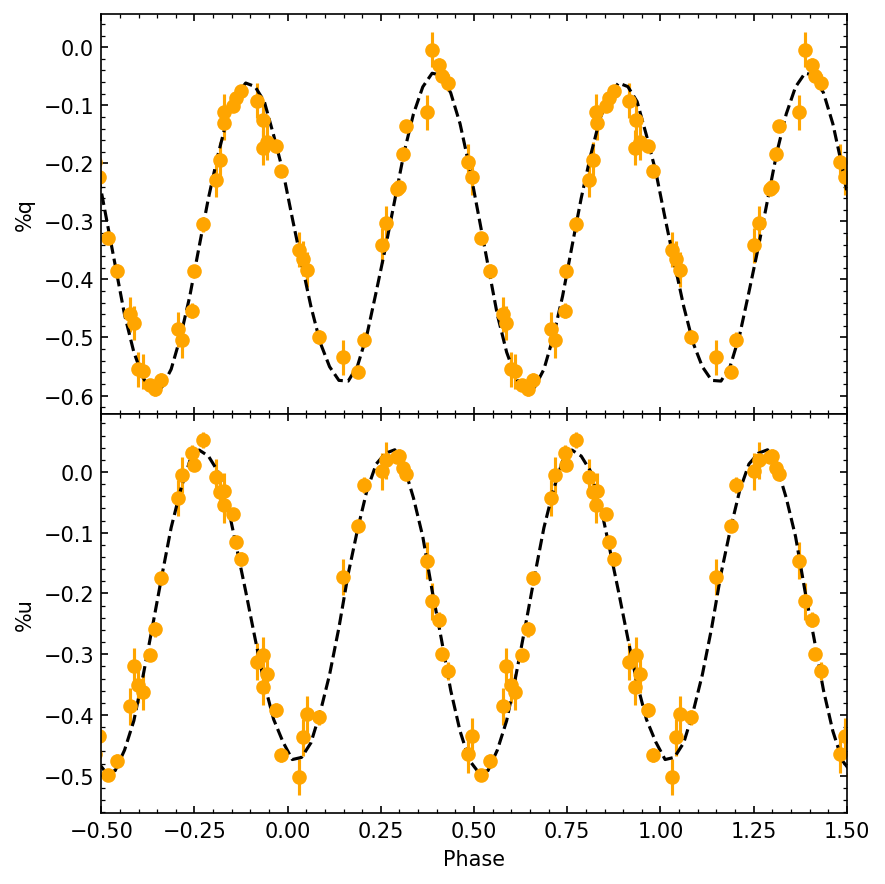

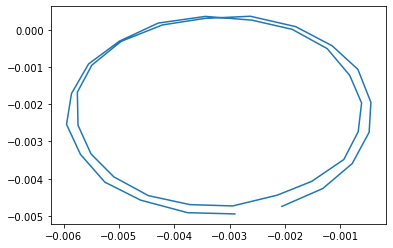

In [21]:
def transform_to_final(x):    
    emulated_q = q_transform_function_nointerp(x)
    emulated_u = u_transform_function_nointerp(x)
    
    pa = calculate_PA(emulated_q, emulated_u)
    
    rotated_q = rotate_q(emulated_q, emulated_u, pa, x[:,4])    
    rotated_u = rotate_u(emulated_q, emulated_u, pa, x[:,4])
    
    prediction_q = vec_sum(rotated_q, x[:,5])
    prediction_u = vec_sum(rotated_u, x[:,6])
    return prediction_q, prediction_u

fig, subplot = plt.subplots(2, 1,figsize = (6, 6), sharex = True, dpi=150)
axQ = subplot.flat[0]
axU = subplot.flat[1]
    
x=np.array(sampler.results["maximum_likelihood"]["point"])

q_model_mle, u_model_mle = transform_to_final(x[None, :])

axQ.set_ylabel('%q')
axQ.errorbar(x=phase_wrap(phase), y=wrap(q_data) * 100, yerr=wrap(qerr) * 100,
             marker='o', ls=' ', color='orange')

axQ.plot(phase_wrap(model_phase), wrap(q_model_mle[0]) * 100, "k--", alpha=1.0)
axQ.set_xlim(-0.5, 1.5)

# ==============================================


axU.set_xlabel('Phase')
axU.set_ylabel('%u')
axU.errorbar(x=phase_wrap(phase), y=wrap(u_data) * 100, yerr=wrap(uerr) * 100,
             marker='o', ls=' ', color='orange')

axU.plot(phase_wrap(model_phase), wrap(u_model_mle[0]) * 100, "k--", alpha=1.0)
axU.set_xlim(-0.5, 1.5)

axQ.minorticks_on()
axU.minorticks_on()
axQ.tick_params(direction="in", which='both', top=True, right=True)
axU.tick_params(direction="in", which='both', top=True, right=True)
fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.figure()
plt.plot(q_model_mle[0], u_model_mle[0])

fig.savefig("final_emulator/WR_127_MLE.pdf")

In [22]:
from IPython.display import display, Math
labels=["nsrc", "\\tau", "ellipse_z", "i", "offset", "q00", "u00"]
for i in range(7):
    mcmc = sampler.results["samples"][0, i]
    if i == 3:
        mcmc = np.rad2deg(np.arccos(mcmc))
    if i > 4:
        mcmc *= 100
    txt = "\mathrm{{{1}}} = {0:.3f}"
    txt = txt.format(mcmc, labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

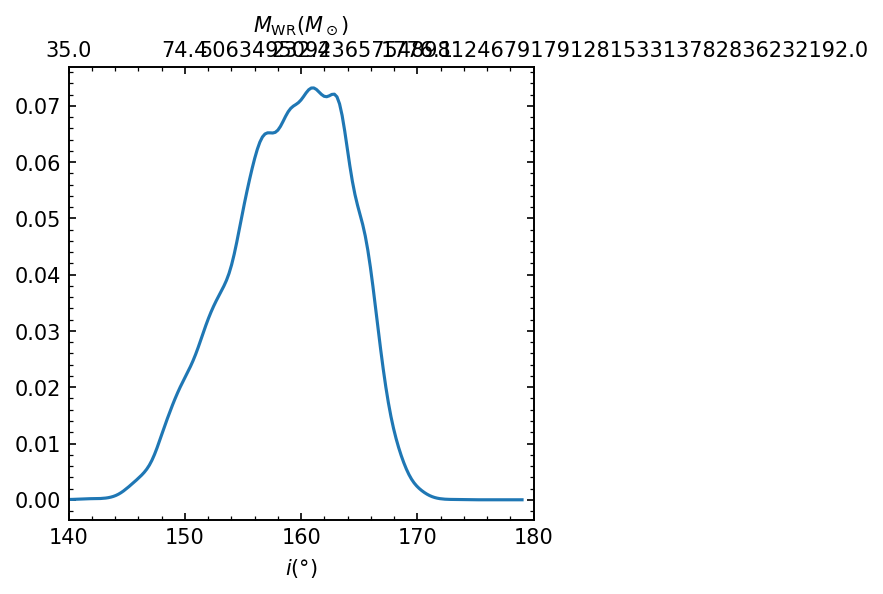

In [27]:
import matplotlib as mpl
import scipy.stats as stats

def tick_function(X):
    V = 9.3 / np.sin(np.deg2rad(X))**3
    return ["%.1f" % z for z in V]

inc_dist = np.rad2deg(np.arccos(sampler.results['samples'][:, 3]))

x_pts = np.linspace(135, 179, 200)

gkde_obj = stats.gaussian_kde(inc_dist)
estimated_pdf = gkde_obj.evaluate(x_pts)

fig, axes = plt.subplots(figsize=(4,4),dpi=150)

fig.set_facecolor("white")

twin_axes=axes.twiny() 
#axes.hist(np.rad2deg(inc_dist), bins=int(np.sqrt(len(inc_dist))))
axes.plot(x_pts, estimated_pdf)

twin_axes.minorticks_on()
axes.minorticks_on()
twin_axes.tick_params(direction="in", which='both', top=True, right=True)
axes.tick_params(direction="in", which='both', top=False, right=True)

axes.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
twin_axes.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))

new_tick_locations = np.linspace(0, 1, 5)
axes.set_xlim(140, 180)
twin_axes.set_xticks(new_tick_locations)
twin_axes.set_xticklabels(tick_function(axes.get_xticks()))
twin_axes.set_xlabel("$M_\mathrm{WR} (M_\odot)$")
axes.set_xlabel("$i (\degree)$");